In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

In [3]:
prices = pd.read_csv('qm_0306.csv', index_col=0)
stocks = prices.columns

In [4]:
prices_form = prices.loc['2003-01-01':'2004-12-31']
prices_trade = prices.loc['2005-01-01':]
returns_trade = prices_trade.pct_change().dropna()

In [5]:
prices_form_norm = (prices_form - prices_form.mean()) / prices_form.std() # normalized prices

# Check that highest correlation is the same as minimized SSD

In [6]:
s1 = prices_form_norm.corr().loc['TRN'].sort_values().index[:-1] # stocks selected correlation
s1[-5:]

Index(['TPR', 'M', 'JNPR', 'JWN', 'FL'], dtype='object')

In [7]:
results = {}

# calculate SSD of all stocks with TRN stock
for stock in stocks[1:]:
    spread = prices_form_norm['TRN'] - prices_form_norm[stock]
    ssd = np.sum(np.square(spread))
    results[stock] = ssd

In [8]:
s2 = pd.DataFrame.from_dict(results, orient='index').sort_values(by=0).index[::-1] # stocks selected SSD
s2[-5:]

Index(['TPR', 'M', 'JNPR', 'JWN', 'FL'], dtype='object')

In [9]:
(s1 != s2).sum()

0

# Trading strategy

In [10]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [11]:
d = 1.9 # position threshold
m = 5 # number of stocks in portfolio

## OLS weighting

In [12]:
import statsmodels.api as sm

positions = pd.DataFrame(index=prices_trade.index, columns=stocks)

for s1 in stocks:
    n_days = 0
    spread = pd.Series(index=prices_trade.index, dtype='float64')

    for t in prices_trade.index:
        prices_tmp = prices.loc[:t].iloc[-494:] # trailing window
        mu = prices_tmp.mean()
        sigma = prices_tmp.std()
        prices_tmp_norm = (prices_tmp - mu) / sigma # normalize prices
        if (n_days % 10) == 0:
            # update portfolio stocks
            pfs = prices_tmp_norm.corr()[s1].sort_values().index[-(m+1):-1] # exclude last one because it is s1
            # update portfolio weights
            model = sm.OLS(prices_tmp_norm[s1], prices_tmp_norm[pfs])
            res = model.fit()
            pfw = res.params # OLS weighting

        spread.loc[t] = prices_tmp_norm.loc[t][s1] - (pfw * prices_tmp_norm.loc[t][pfs]).sum()
        n_days += 1

        if spread.loc[t] >= d:
            positions[s1].loc[t] = -1 # short position
        elif spread.loc[t] <= -d:
            positions[s1].loc[t] = 1 # long position
        else:
            positions[s1].loc[t] = 0

In [13]:
cumret_ols = np.nancumprod((positions.shift().dropna() * returns_trade).sum(axis=1) 
                           / len(returns_trade.columns) + 1)

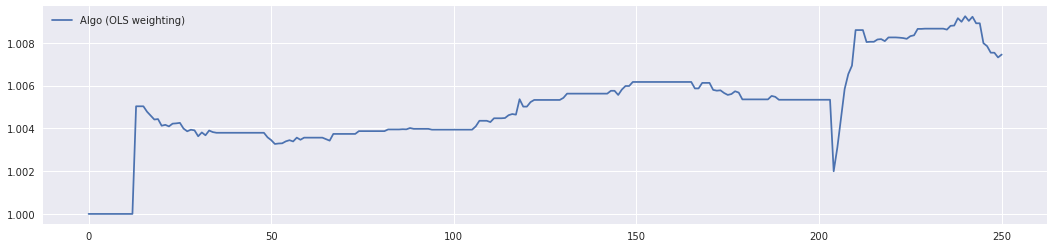

In [14]:
plt.figure(figsize=(18,4))
plt.plot(cumret_ols, label='Algo (OLS weighting)')
plt.legend()

In [15]:
abs(positions).sum().sum()

160

In [16]:
# limit the total number of positions on any given day to three
positions_3p = positions.copy()
positions_3p[abs(positions_3p).cumsum(axis=1)>3] = 0

In [17]:
cumret_ols_3p = np.nancumprod((positions_3p.shift().dropna() * returns_trade).sum(axis=1) / 3 + 1)

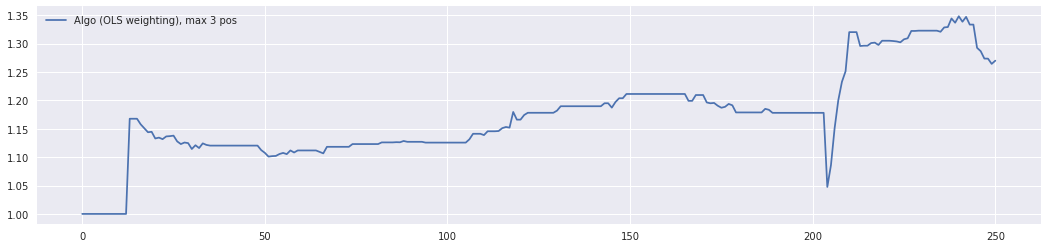

In [18]:
plt.figure(figsize=(18,4))
plt.plot(cumret_ols_3p, label='Algo (OLS weighting), max 3 pos')
plt.legend()

In [19]:
import random

def shuffle_positions(positions_df):
    
    positions = positions_df.copy().values
    
    # shuffle positions within each column
    for col in range(positions.shape[1]):
        split =  np.split(positions[:,col], np.where((np.diff(positions[:,col]) != 0))[0]+1)
        pos = [x for x in split if x[0]!=0] # all non-zero positions
        pos_length = sum([len(x) for x in pos]) # total length in days
        zero_length = len(positions[:,col]) - pos_length
        pos += np.split(np.array([0]*zero_length), np.arange(1,zero_length))
        random.shuffle(pos)
        pos = np.concatenate(pos).astype(int)
        positions[:,col] = pos
    # shuffle columns
    np.random.shuffle(np.transpose(positions))
    
    shuffled_df = pd.DataFrame(positions, index=positions_df.index, columns=positions_df.columns)
    
    return shuffled_df

In [20]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / len(returns_trade.columns) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [21]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_ols)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (OLS weighting)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [22]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Algo (OLS weighting),0.007449,0.007479,1.071336,-0.004149,102.0,99.42


In [23]:
# repeat for the version with 3 positions
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions_3p)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / 3 + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0])
    
bootstrap_trs = np.array(bootstrap_trs)

In [24]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_ols_3p)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (OLS weighting) 3 pos'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [25]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Algo (OLS weighting),0.007449,0.007479,1.071336,-0.004149,102.0,99.42
Algo (OLS weighting) 3 pos,0.269952,0.271161,1.132143,-0.135217,102.0,99.58


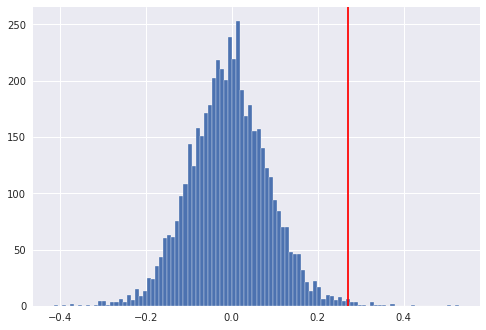

In [26]:
_ = plt.hist(bootstrap_trs, bins=100)
plt.axvline(x=total_return, c='r')

## equal weighting

In [27]:
positions = pd.DataFrame(index=prices_trade.index, columns=stocks)

for s1 in stocks:
    n_days = 0
    spread = pd.Series(index=prices_trade.index, dtype='float64')

    for t in prices_trade.index:
        prices_tmp = prices.loc[:t].iloc[-494:] # trailing window
        mu = prices_tmp.mean()
        sigma = prices_tmp.std()
        prices_tmp_norm = (prices_tmp - mu) / sigma # normalize prices
        if (n_days % 10) == 0:
            # update pair portfolio stocks
            pfs = prices_tmp_norm.corr()[s1].sort_values().index[-(m+1):-1] # exclude last one because it is s1
            # update pair portfolio weights
            pfw = 1/len(pfs) # equal weighting

        spread.loc[t] = prices_tmp_norm.loc[t][s1] - (pfw * prices_tmp_norm.loc[t][pfs]).sum()
        n_days += 1

        if spread.loc[t] >= d:
            positions[s1].loc[t] = -1
        elif spread.loc[t] <= -d:
            positions[s1].loc[t] = 1
        else:
            positions[s1].loc[t] = 0

In [28]:
cumret_equal = np.nancumprod((positions.shift().dropna() * returns_trade).sum(axis=1) 
                             / len(returns_trade.columns) + 1)

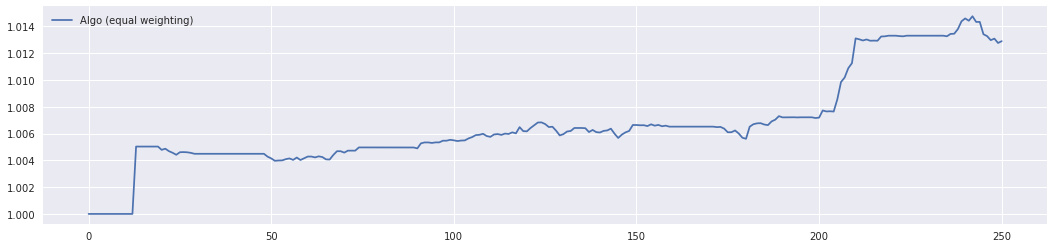

In [29]:
plt.figure(figsize=(18,4))
plt.plot(cumret_equal, label='Algo (equal weighting)')
plt.legend()

In [30]:
abs(positions).sum().sum()

269

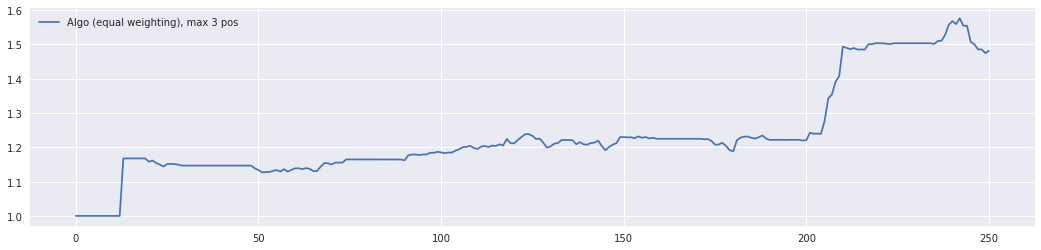

In [31]:
# limit the total number of positions on any given day to three
positions_3p = positions.copy()
positions_3p[abs(positions_3p).cumsum(axis=1)>3] = 0
cumret_equal_3p = np.nancumprod((positions_3p.shift().dropna() * returns_trade).sum(axis=1) / 3 + 1)
plt.figure(figsize=(18,4))
plt.plot(cumret_equal_3p, label='Algo (equal weighting), max 3 pos')
plt.legend()

In [32]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / len(returns_trade.columns) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [33]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_equal)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (equal weighting)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [34]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Algo (OLS weighting),0.007449,0.007479,1.071336,-0.004149,102.0,99.42
Algo (OLS weighting) 3 pos,0.269952,0.271161,1.132143,-0.135217,102.0,99.58
Algo (equal weighting),0.012902,0.012954,2.107272,-0.001968,71.0,99.78


In [35]:
# repeat for the version with 3 positions
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions_3p)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / 3 + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0])
    
bootstrap_trs = np.array(bootstrap_trs)

In [36]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_equal_3p)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (equal weighting) 3 pos'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [37]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Algo (OLS weighting),0.007449,0.007479,1.071336,-0.004149,102.0,99.42
Algo (OLS weighting) 3 pos,0.269952,0.271161,1.132143,-0.135217,102.0,99.58
Algo (equal weighting),0.012902,0.012954,2.107272,-0.001968,71.0,99.78
Algo (equal weighting) 3 pos,0.481495,0.483817,2.016000,-0.064503,76.0,99.78


## correlation weighting

In [38]:
positions = pd.DataFrame(index=prices_trade.index, columns=stocks)

for s1 in stocks:
    n_days = 0
    spread = pd.Series(index=prices_trade.index, dtype='float64')

    for t in prices_trade.index:
        prices_tmp = prices.loc[:t].iloc[-494:] # trailing window
        mu = prices_tmp.mean()
        sigma = prices_tmp.std()
        prices_tmp_norm = (prices_tmp - mu) / sigma # normalize prices
        if (n_days % 10) == 0:
            # update pair portfolio stocks
            pfs = prices_tmp_norm.corr()[s1].sort_values().index[-(m+1):-1] # exclude last one because it is s1
            # update pair portfolio weights
            pfw = prices_tmp_norm.corr()[s1][pfs] / prices_tmp_norm.corr()[s1][pfs].sum() # correlation weighting

        spread.loc[t] = prices_tmp_norm.loc[t][s1] - (pfw * prices_tmp_norm.loc[t][pfs]).sum()
        n_days += 1

        if spread.loc[t] >= d:
            positions[s1].loc[t] = -1
        elif spread.loc[t] <= -d:
            positions[s1].loc[t] = 1
        else:
            positions[s1].loc[t] = 0

In [39]:
cumret_corr = np.nancumprod((positions.shift().dropna() * returns_trade).sum(axis=1) 
                             / len(returns_trade.columns) + 1)

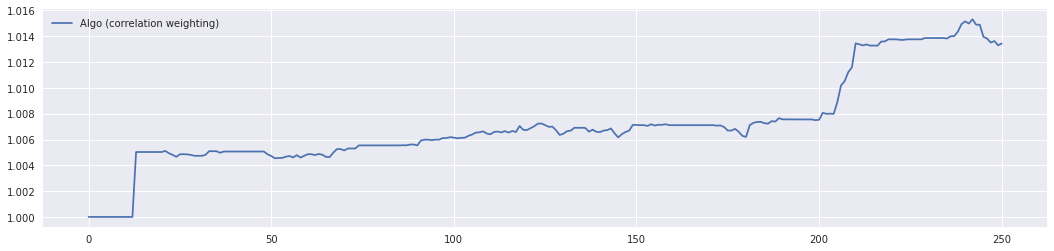

In [40]:
plt.figure(figsize=(18,4))
plt.plot(cumret_corr, label='Algo (correlation weighting)')
plt.legend()

In [41]:
abs(positions).sum().sum()

266

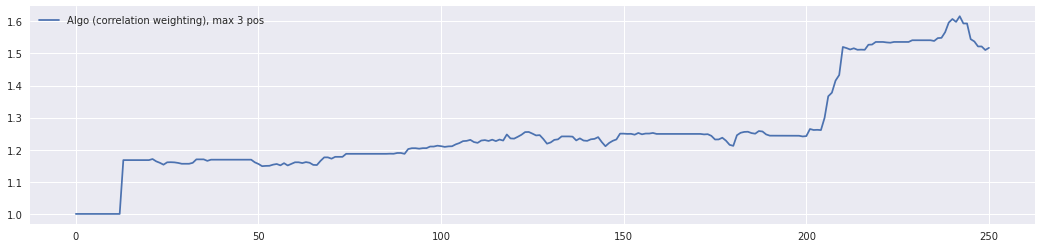

In [42]:
# limit the total number of positions on any given day to three
positions_3p = positions.copy()
positions_3p[abs(positions_3p).cumsum(axis=1)>3] = 0
cumret_corr_3p = np.nancumprod((positions_3p.shift().dropna() * returns_trade).sum(axis=1) / 3 + 1)
plt.figure(figsize=(18,4))
plt.plot(cumret_corr_3p, label='Algo (correlation weighting), max 3 pos')
plt.legend()

In [43]:
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / len(returns_trade.columns) + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return
    
bootstrap_trs = np.array(bootstrap_trs)

In [44]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_corr)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (correlation weighting)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [45]:
# repeat for the version with 3 positions
bootstrap_trs = [] # total returns

for N in range(5000):
    positions_bootstrap = shuffle_positions(positions_3p)
    cumret_bootstrap = np.nancumprod((positions_bootstrap.shift().dropna() * returns_trade).sum(axis=1) 
                                / 3 + 1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0])
    
bootstrap_trs = np.array(bootstrap_trs)

In [46]:
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_corr_3p)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (correlation weighting) 3 pos'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [47]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Algo (OLS weighting),0.007449,0.007479,1.071336,-0.004149,102.0,99.42
Algo (OLS weighting) 3 pos,0.269952,0.271161,1.132143,-0.135217,102.0,99.58
Algo (equal weighting),0.012902,0.012954,2.107272,-0.001968,71.0,99.78
Algo (equal weighting) 3 pos,0.481495,0.483817,2.016000,-0.064503,76.0,99.78
Algo (correlation weighting),0.013440,0.013494,2.196853,-0.001988,57.0,99.84
Algo (correlation weighting) 3 pos,0.517428,0.519952,2.134019,-0.065133,58.0,99.86
